In [1]:
import getpass
import sys
import pandas as pd
import string

from src.common.authentication import Authentication
from src.common.perspective_api_request import PerspectiveAPIRequest, PerspectiveAPIRequestResult
from src.common.request import Request, RequestResult
from src.proxy.accounts import Account
from proxy.remote_service import RemoteService

from os.path import exists

In [2]:
# An example of how to use the request API.
#api_key = getpass.getpass(prompt="Enter a valid API key: ")
api_key = pd.read_csv("prod_env/api_key.csv", header=None)[0].values[0]
auth = Authentication(api_key=api_key)
service = RemoteService("https://crfm-models.stanford.edu")

# Access account and show my current quotas and usages
account: Account = service.get_account(auth)
print(account.usages)

{'gpt3': {'daily': Usage(period='2022-8-15', used=79271, quota=None), 'total': Usage(period='all', used=166579, quota=400000), 'monthly': Usage(period='2022-8', used=129382, quota=None)}, 'codex': {'daily': Usage(period=None, used=0, quota=0)}, 'jurassic': {'daily': Usage(period=None, used=0, quota=None), 'total': Usage(period=None, used=0, quota=0)}, 'gooseai': {'daily': Usage(period=None, used=0, quota=0)}}


In [3]:
def get_processed_countries(OUTPUT_FILE):
    processed_countries = set()
    if exists(OUTPUT_FILE):
        processed_countries = set(list(pd.read_csv(OUTPUT_FILE, header=None)[1].values))
    return processed_countries

In [4]:
NUM_COMPLETIONS = 1
MAX_TOKENS = 50
TEMPERATURE = 0.7
MODEL_NAME = "openai/davinci"

prompt_responses = pd.DataFrame()

OUTPUT_FILE = 'interpretability/country_results/' + str(MAX_TOKENS) + "_" + str(TEMPERATURE)[-1:] + "_" + MODEL_NAME[7:] + '.csv'

countries = list(pd.read_csv("interpretability/data/un_countries_meta.csv")['Name'].values)
processed_countries = get_processed_countries(OUTPUT_FILE)

# for prompt_country in countries:

#     PROMPT = "Q: What is the capital of Canada? A: I would guess it's Ottawa. Q: What is capital of France? A: I would guess it's Paris. Q: What's the capital of " + prompt_country + "? A: I would guess it's"
#     request = Request(prompt=PROMPT, temperature=TEMPERATURE, model=MODEL_NAME, num_completions=NUM_COMPLETIONS, max_tokens=MAX_TOKENS, stop_sequences=["?", ".", "\n"])
#     request_result: RequestResult = service.make_request(auth, request)
    
#     result = request_result.completions[0]
#     prompt_country_answer = result.text
#     prompt_country_logprob = result.logprob
#     print(prompt_country + "," + result.text + "," + str(result.logprob))

#     prompt_responses = pd.concat([prompt_responses, pd.DataFrame([[PROMPT, prompt_country, prompt_country_answer, prompt_country_logprob]])])

# prompt_responses.to_csv(OUTPUT_FILE, mode='a', header=False, index=False)



In [5]:
request_result.completions[0]



NameError: name 'request_result' is not defined

In [6]:
countries_meta_data = pd.read_csv("interpretability/data/capitals_data.csv")
countries_meta_data = countries_meta_data[['name', 'region', 'gdp', 'gdp_logged', 'capital']]


In [7]:
#lowercase, remove punctuation, and whitespacing
def remove_punctuation(str_input):
    return str_input.translate(str.maketrans('', '', string.punctuation + 'ʻ'+ ' ')).lower()


In [8]:
PATH = 'interpretability/country_results/' 
IMSURE = PATH + '/50_7_davinci_Im_pretty_sure.csv'
IDONTKNOW = PATH + '/50_7_davinci_I_dont_know.csv'
UNPROMPTED = PATH + '/50_7_davinci_unprompted.csv'
ITHINK = PATH + '/50_7_davinci_ithink.csv'
IGUESS = PATH + '/50_7_davinci_iguess.csv'

def get_country_results(filename):
    countries_results = pd.read_csv(filename, header=None).drop_duplicates()
    countries_results.columns = ['prompt', 'country', 'predicted', 'logprob']
    countries_results = countries_results.drop('prompt', axis=1)
    countries_results = countries_results.set_index("country").join(countries_meta_data[['name', 'capital']].set_index("name"))
    countries_results['predicted'] = countries_results['predicted'].apply(lambda x: str(x).strip())
    #check if the capital is in the answer (no partial credits)
    countries_results['correct'] = countries_results.apply(lambda x: 1 if remove_punctuation(x['capital']) in remove_punctuation(x['predicted']) else 0, axis=1)
    countries_results = countries_results.drop('capital', axis=1)
    countries_results = countries_results.reset_index(drop=False)
    countries_results.columns = ['country', 'predicted', 'logprob', 'correct']
    return countries_results

sure_df = get_country_results(IMSURE)
dontknow_df = get_country_results(IDONTKNOW)
unprompted_df = get_country_results(UNPROMPTED)
ithink_df = get_country_results(ITHINK)
iguess_df = get_country_results(IGUESS)



In [9]:
joined = sure_df.set_index("country").join(dontknow_df.set_index("country"), rsuffix='_dontknow', lsuffix='_sure').reset_index()
joined = joined.set_index("country").join(unprompted_df.set_index("country"), rsuffix='_unprompted').reset_index()
joined = joined.set_index("country").join(ithink_df.set_index("country"), rsuffix='_ithink').reset_index()
joined = joined.set_index("country").join(iguess_df.set_index("country"), rsuffix='_iguess').reset_index()
joined = joined.set_index("country").join(countries_meta_data.set_index("name")).reset_index()



<AxesSubplot:title={'center':'Average Accuracy Across Regions with Varying Prompts'}, xlabel='Region', ylabel='Average Accuracy'>

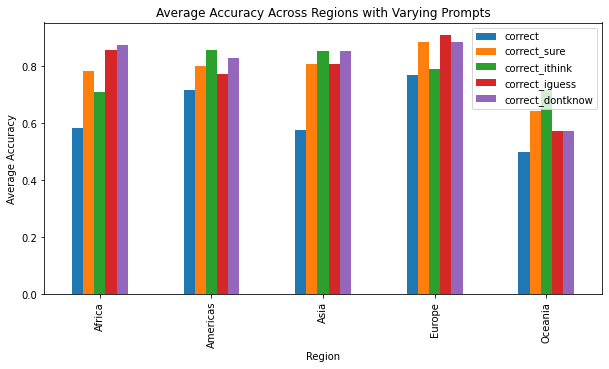

In [10]:
joined.groupby('region').mean()[['correct', 'correct_sure', 'correct_ithink', 'correct_iguess', 'correct_dontknow']].plot.bar(figsize=(10, 5),
                                                                                                           ylabel='Average Accuracy',
                                                                                                           xlabel = 'Region',
                                                                                                           title = 'Average Accuracy Across Regions with Varying Prompts')


<AxesSubplot:title={'center':'Average Logprob Across Regions with Varying Prompts'}, xlabel='Region', ylabel='Average Accuracy'>

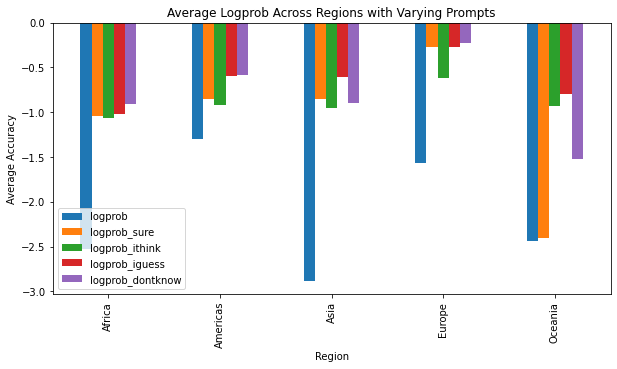

In [11]:
joined.groupby('region').mean()[['logprob', 'logprob_sure', 'logprob_ithink', 'logprob_iguess', 'logprob_dontknow']].plot.bar(figsize=(10, 5),
                                                                                                           ylabel='Average Accuracy',
                                                                                                           xlabel = 'Region',
                                                                                                           title = 'Average Logprob Across Regions with Varying Prompts')


In [12]:
best_prediction_array = []
for n, row in joined.iterrows():
    #set a very negative value
    best_prediction = -1000
    #go through all the types of prompts
    for x in ['_sure', '_dontknow', '_ithink', '_iguess']:
        #if the logprob is higher, then set that to be the best value
        if row['logprob' + x] > best_prediction:
            best_prediction = row['logprob' + x]
            best_prediction_value = row['correct' + x]
        
    best_prediction_array.append(best_prediction_value)

joined['best_prediction'] = best_prediction_array
joined.mean()

/tmp/ipykernel_593989/902231873.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  joined.mean()


logprob_sure            -0.890874
correct_sure             0.804124
logprob_dontknow        -0.743251
correct_dontknow         0.840206
logprob                 -2.173469
correct                  0.639175
logprob_ithink          -0.903956
correct_ithink           0.788660
logprob_iguess          -0.665875
correct_iguess           0.819588
gdp                 444669.809278
gdp_logged              10.459484
best_prediction          0.891753
dtype: float64

In [13]:
sure_correct.mean()


NameError: name 'sure_correct' is not defined

In [21]:
dontknow_correct.mean()

/tmp/ipykernel_151626/2943489522.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dontknow_correct.mean()


logprob_dontknow   -0.660652
logprob_sure       -3.080641
dtype: float64

KeyError: 'gdp_logged'

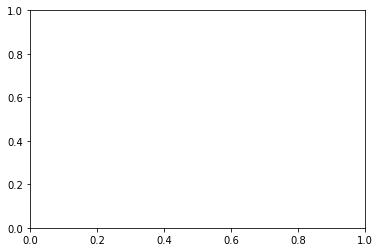

In [149]:
sure_df.plot.scatter(x='gdp_logged', y='logprob')
print(sure_df[['gdp_logged', 'logprob']].corr("pearson"))

            gdp_logged   logprob
gdp_logged    1.000000  0.105766
logprob       0.105766  1.000000


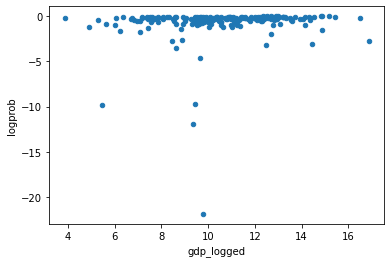

In [148]:
dontknow_df.plot.scatter(x='gdp_logged', y='logprob')
print(dontknow_df[['gdp_logged', 'logprob']].corr("pearson"))

In [134]:
dontknow_df

,country,prompt,predicted,logprob,region,gdp,capital,correct
0,country,prompt,predicted,logprob,NaN,NaN,NaN,0
1,Afghanistan,Q: What is the capital of Canada? A: I don't k...,Kabul,-0.38779223,Asia,17876.0,Kabul,1
2,Mali,Q: What is the capital of Canada? A: I don't k...,Bamako,-0.05891444784,Africa,17432.0,Bamako,1
3,Malta,Q: What is the capital of Canada? A: I don't k...,Valletta,-0.822813826,Europe,14863.0,Valletta,1
4,Mexico,Q: What is the capital of Canada? A: I don't k...,Mexico City,-0.31924852,Americas,1256440.0,Mexico City,1
...,...,...,...,...,...,...,...,...
189,Antigua and Barbuda,Q: What is the capital of Canada? A: I don't k...,St,-1.2997102,Americas,1661.0,St. John's,0
190,Cote d'Ivoire,Q: What is the capital of Canada? A: I don't k...,Abidjan,-0.9994368575,Africa,58539.0,Abidjan,1
191,Saint Kitts and Nevis,Q: What is the capital of Canada? A: I don't k...,Basseterre,-0.5390455976,Americas,1050.0,Basseterre,1
192,Saint Vincent and the Grenadines,Q: What is the capital of Canada? A: I don't k...,Kingstown,-0.2612656519,Americas,825.0,Kingstown,1
